<a href="https://colab.research.google.com/github/gibiee/study_AI/blob/master/%5Bpytorch%5D%20CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose( [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


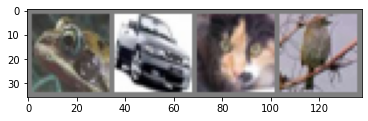

 frog   car   cat  bird


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [20]:
import torch.optim as optim
import datetime
start_time = datetime.datetime.now()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):   # 데이터셋을 수차례 반복합니다.
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data
        
        # GPU 사용시 아래 코드로 작성해야함.
        # inputs, labels = data[0].to(device), data[1].to(device)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999 :    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')
print('소요된 시간 : ', datetime.datetime.now() - start_time)
# CPU 학습에 소요된 시간 : 약 1분 50초
# GPU 학습에 소요된 시간 : 약 1분 40초

[1,  2000] loss: 1.290
[1,  4000] loss: 1.238
[1,  6000] loss: 1.229
[1,  8000] loss: 1.219
[1, 10000] loss: 1.243
[1, 12000] loss: 1.216
[2,  2000] loss: 1.150
[2,  4000] loss: 1.140
[2,  6000] loss: 1.145
[2,  8000] loss: 1.129
[2, 10000] loss: 1.123
[2, 12000] loss: 1.133
Finished Training
소요된 시간 :  0:01:38.579099


In [0]:
# 생성된 모델을 파일으로 저장
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

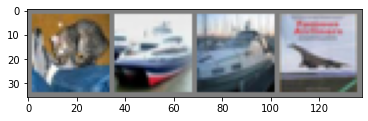

GroundTruth:    cat  ship  ship plane


In [8]:
# 테스트 데이터로 테스트하기
dataiter = iter(testloader)
images, labels = dataiter.next()

# 이미지와 정답을 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship plane  ship


In [10]:
# 전체 데이터셋에 대해서 분류
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


In [11]:
# 어떤 것을 잘 분류하기 어떤 것을 잘 분류하지 못했는지 분석
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 61 %
Accuracy of   car : 56 %
Accuracy of  bird : 39 %
Accuracy of   cat : 22 %
Accuracy of  deer : 51 %
Accuracy of   dog : 59 %
Accuracy of  frog : 66 %
Accuracy of horse : 65 %
Accuracy of  ship : 52 %
Accuracy of truck : 61 %


In [18]:
# GPU 를 사용할 수 있는지 확인하는 코드
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# CUDA 기기가 존재한다면, CUDA 장치를 출력합니다:
print(device)

# 이 메소드(Method)들은 재귀적으로 모든 모듈의 매개변수와 버퍼를 CUDA tensor로 변경합니다:
net.to(device)

# GPU 학습을 진행하려면 아래 코드를 학습 과정에 삽입해주어야함. (위의 학습 코드를 참고)
# inputs, labels = data[0].to(device), data[1].to(device)

cuda:0
